#
# Load squad2.0 train .json onto df
#

In [1]:
import json, requests
import pandas as pd
from tqdm import tqdm

In [2]:
# Load the SQuAD 2.0 JSON file
# URL of the SQuAD 2.0 dataset
url = 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json'

# Fetch the content from the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Load the JSON content into a dictionary
    squad_data = response.json()

In [3]:
# Initialize lists to hold flattened data
data_list = []

# Use tqdm to add a progress bar to the outer loop
for article in tqdm(squad_data['data'], desc='Processing Articles'):
    title = article['title']
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            question = qa['question']
            qid = qa['id']
            is_impossible = qa.get('is_impossible', False)
            answers = qa.get('answers', [])
            if not is_impossible:
                for answer in answers:
                    answer_text = answer['text']
                    answer_start = answer['answer_start']
                    data_list.append({
                        'title': title,
                        'context': context,
                        'question': question,
                        'id': qid,
                        'is_impossible': is_impossible,
                        'answer_text': answer_text,
                        'answer_start': answer_start
                    })
            else:
                # For unanswerable questions, append with empty answer fields
                data_list.append({
                    'title': title,
                    'context': context,
                    'question': question,
                    'id': qid,
                    'is_impossible': is_impossible,
                    'answer_text': None,
                    'answer_start': None
                })

# Convert list of records to a DataFrame
df = pd.DataFrame(data_list)
df.set_index("id", inplace=True)

# Display the DataFrame
print(df.head())

Processing Articles: 100%|██████████| 442/442 [00:00<00:00, 4561.79it/s]


                            title  \
id                                  
56be85543aeaaa14008c9063  Beyoncé   
56be85543aeaaa14008c9065  Beyoncé   
56be85543aeaaa14008c9066  Beyoncé   
56bf6b0f3aeaaa14008c9601  Beyoncé   
56bf6b0f3aeaaa14008c9602  Beyoncé   

                                                                    context  \
id                                                                            
56be85543aeaaa14008c9063  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
56be85543aeaaa14008c9065  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
56be85543aeaaa14008c9066  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
56bf6b0f3aeaaa14008c9601  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
56bf6b0f3aeaaa14008c9602  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   

                                                                   question  \
id                                                                            
56be85543aeaaa14008c9063    

In [4]:
df.sample(5)

,title,context,question,is_impossible,answer_text,answer_start
id,,,,,,
57327238e99e3014001e67ba,Dwight_D._Eisenhower,"In July 1953, an armistice took effect with Ko...",Who described the armistice as Eisenhower's gr...,False,Ambrose,388.0
5acec39532bba1001ae4b333,Athanasius_of_Alexandria,The accession of Valens gave a fresh lease of ...,What happened on October 4?,True,None,NaN
5a1e1c4b3de3f40018b264d6,Hokkien,Hokkien dialects are typically written using C...,What is adapted to the spoken form of Chinese?,True,None,NaN
56de523ccffd8e1900b4b809,Institute_of_technology,Most of Thailand's institutes of technology we...,What type of degree were Thailand's technical ...,False,bachelor's degrees,112.0
5a85e576b4e223001a8e728a,Poultry,The greylag goose (Anser anser) was domesticat...,What other name is the swan goose no longer kn...,True,None,NaN


Evaluation on LLM-RAG:

1. Retrieval - RAG retrieved the needed context? <br>
2. Relevance - LLM deciphered the relevant context? <br>
3. Accuracy - LLM answer contains the answer <br>
4. Precision - LLM answer does not contain irrelevant answer <br>







#
# Multi-Ollama for Concurrent Invokes
#

In [5]:
import itertools
from langchain_community.llms import Ollama
from langchain.prompts import PromptTemplate

import deh.settings as settings
import deh.guardrail as guardrail
from deh.utils import format_context_documents as format_docs
from deh.utils import retriever_with_scores, dedupulicate_contexts
from deh.prompts import (
    qa_eval_prompt_with_context_text,
    LLMEvalResult,
    rag_text_prompts,
    hyde_prompts,
)
import deh

In [6]:
# Set up load balancing between the two instances
nLLM = 8
LLM = [Ollama(
            base_url=settings.OLLAMA_HOST, model=settings.LLM_MODEL, verbose=True
        ) for i in range(nLLM)
      ] 

print(len(LLM))
print(LLM[-1])

# Create a round-robin iterator using itertools.cycle
round_robin_models = itertools.cycle(LLM)

def LLMinvoke(prompt):
    # Get the next model in the round-robin cycle
    selected_model = next(round_robin_models)
    
    # Invoke the selected model with the prompt
    response = selected_model.invoke(prompt)
    return response

8
Ollama
Params: {'model': 'llama3.1:8b-instruct-q3_K_L', 'format': None, 'options': {'mirostat': None, 'mirostat_eta': None, 'mirostat_tau': None, 'num_ctx': None, 'num_gpu': None, 'num_thread': None, 'num_predict': None, 'repeat_last_n': None, 'repeat_penalty': None, 'temperature': None, 'stop': None, 'tfs_z': None, 'top_k': None, 'top_p': None}, 'system': None, 'template': None, 'keep_alive': None, 'raw': None}


/tmp/ipykernel_24/2320936863.py:3: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  LLM = [Ollama(


In [7]:
row = 0
q = df.iloc[row]["question"]
c = df.iloc[row]["context"]
gt = df.iloc[row]["answer_text"]

# Initial LLM generation prompt:
qa_prompt = PromptTemplate(
    template=rag_text_prompts[0], input_variables=["question", "context"]
)

chain = qa_prompt | LLMinvoke
llmans = chain.invoke({"question": q, "context": c})

print(llmans)

Beyonce started becoming popular in the late 1990s as lead singer of R&B girl-group Destiny's Child. This was followed by her solo debut album, Dangerously in Love, released in 2003, which established her as a solo artist worldwide. The album featured two number-one singles, "Crazy in Love" and "Baby Boy".


In [8]:
print(q)
print(c)
print(gt)
print(chain)

When did Beyonce start becoming popular?
Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
in the late 1990s
first=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="\n    You are an assistant for question-answering tasks.\n    Use the following pieces of retrieved context to answer the question.\n   

In [9]:
import asyncio
from tqdm.asyncio import tqdm_asyncio
import nest_asyncio

nest_asyncio.apply()

# Assuming chain.invoke is an asynchronous function
async def invoke_chain(chain, q, c, semaphore, pbar):
    async with semaphore:
        pbar.update(1)
        return await chain.ainvoke({"question": q, "context": c})

async def main(df = None, LLM = None, n=50, clim=8):
    # input validation 
    if df.empty:
        raise ValueError("The DataFrame is empty")
    assert (LLM != None)
    
    # Initial LLM generation prompt:
    qa_prompt = PromptTemplate(
        template=rag_text_prompts[0], input_variables=["question", "context"]
    )
    chain = qa_prompt | LLMinvoke

    # Create a semaphore with a limit on concurrent tasks
    semaphore = asyncio.Semaphore(clim)

    # Create a tqdm progress bar
    samdf = df.sample(n, random_state=42)
    with tqdm(total=n, desc="Processing") as pbar:
        tasks = [invoke_chain(chain, row['question'], row['context'], semaphore, pbar) for _, row in samdf.iterrows()]
        results = await asyncio.gather(*tasks)

    return results

In [10]:
# Run the main function
results = await main(df, LLM, 100, 32)

Processing: 100%|██████████| 100/100 [02:54<00:00,  1.74s/it]


In [11]:
# Print the results
for i in range(10): 
    print(str(i) + " : " + results[i])

0 : The global recession that followed the financial crisis of 2007 ended in 2012. This period of economic downturn lasted for approximately five years. The exact timing and severity of the end varied across regions.
1 : One popular club in Ibiza that started playing dance and house music was Amnesia, specifically with DJ Alfredo. This club played a mix of rock, pop, disco, and house music. It had a distinctive sound fueled by Ecstasy and later influenced the UK club scene.
2 : The 16th century is when Martin Luther honored Mary as the Mother of God, alongside Calvin and Huldrych Zwingli, but less so than them. This was a time before the idea of Marian veneration became associated with Catholics, leading to decreased interest in Mary among Protestants. The decline continued during the Age of the Enlightenment.
3 : The climate in Himachal varies greatly due to its varying elevation, ranging from hot and subhumid tropical to cold and alpine. It experiences three seasons: summer, winter, 

In [ ]:
ans_len = df["answer_text"].str.split().str.len()
print(ans_len.mean())
print(ans_len.std())

#
# Visualization of words counts
#

In [13]:
!pip install matplotlib seaborn

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


<Figure size 1000x600 with 0 Axes>

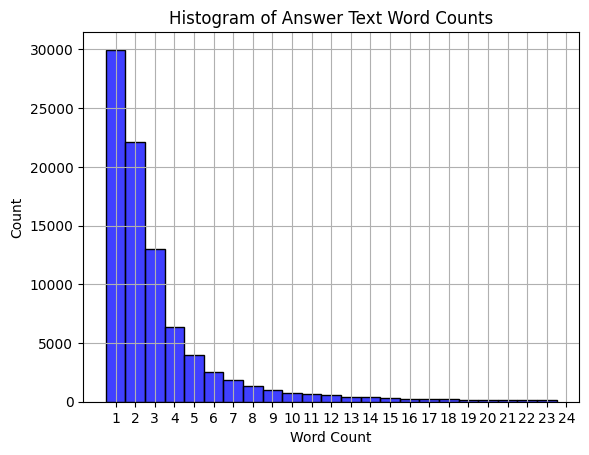

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
bins = [i for i in range(1,25)]
print(bins)

# Step 1: Create the histogram 
fig, ax1 = plt.subplots()
sns.histplot(ans_len, bins=bins, kde=False, stat='count', color='blue', edgecolor='black', ax=ax1)
ax1.set_ylabel('Count')
#ax1.set_yscale('log')

# Step 2: Density Curve
#ax2 = ax1.twinx()
#sns.histplot(ans_len, bins=bins, kde=True, stat='density', color='red', edgecolor='black', ax=ax2)
#ax2.set_ylabel('Density')

# Step 3: Add labels and title
plt.title('Histogram of Answer Text Word Counts')
plt.xlabel('Word Count')
plt.xticks([b + 0.5 for b in bins], bins)
plt.grid(True)

# Show the plot
plt.show()

In [43]:
print((ans_len > 10).sum())

3915


In [44]:
df[ans_len > 10]["answer_text"].sample(10).tolist()

["devastating effects the job can have on one's life and health",
 'set up the Shoah Foundation, a non-profit organization that archives filmed testimony of Holocaust survivors',
 'These "classical" concepts fail to adequately account for change, and overlook the active and experiential nature of the most basic elements of the world.',
 'The presence of gas molecules knocks the liberated tungsten atoms back to the filament',
 'Spanish were never able to effectively police the border region and the backwoods settlers',
 'government funds to pay for transportation of students to both public and Catholic schools',
 "Amer's allies in the officers corps threatened to mobilize against him",
 'one of the Masterpieces of the Oral and Intangible Heritage of Humanity',
 'as a means for the weak to collectively constrain the strong.',
 'When a high-speed USB 2.0 hub is plugged into a high-speed USB host or hub']

#
# Vectorize to Milvus
#

In [48]:
import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

# Load SPLADE model
splade_tokenizer = AutoTokenizer.from_pretrained("naver/splade-cocondenser-ensembledistil")
splade_model = AutoModel.from_pretrained("naver/splade-cocondenser-ensembledistil").to('cuda')
# Load ALL-MPNET-BASE-V2 model
mpnet_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
mpnet_model = mpnet_model.to('cuda')

Some weights of BertModel were not initialized from the model checkpoint at naver/splade-cocondenser-ensembledistil and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
# Vectorize using ALL-MPNET-BASE-V2 with tqdm progress bar
def vectorize_mpnet_batch(texts):
    embeddings = []
    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc="Vectorizing with ALL-MPNET-BASE-V2"):
        batch_texts = texts[i:i+BATCH_SIZE]
        valid_texts = [text if isinstance(text, str) else "" for text in batch_texts]
        batch_embeddings = mpnet_model.encode(valid_texts, device='cuda', batch_size=BATCH_SIZE)
        embeddings.extend(batch_embeddings)
    return embeddings

BATCH_SIZE = 512
mpnet_embeddings = vectorize_mpnet_batch(df['answer_text'].tolist())

Vectorizing with ALL-MPNET-BASE-V2: 100%|██████████| 255/255 [01:56<00:00,  2.18it/s]


In [60]:
mpnet_model.to('cpu')
del mpnet_model
torch.cuda.empty_cache()

In [61]:
# Vectorize using SPLADE with tqdm for progress bar (on GPU)
def vectorize_splade_batch(texts):
    embeddings = []
    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc="Vectorizing with SPLADE"):
        batch_texts = texts[i:i+BATCH_SIZE]
        valid_texts = [text if isinstance(text, str) else "" for text in batch_texts]
        inputs = splade_tokenizer(valid_texts, padding=True, truncation=True, return_tensors='pt').to('cuda')
        with torch.no_grad():
            outputs = splade_model(**inputs)
            pooled_output = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.extend(pooled_output)
    return embeddings

BATCH_SIZE = 512
splade_embeddings = vectorize_splade_batch(df['answer_text'].tolist())

Vectorizing with SPLADE: 100%|██████████| 255/255 [01:48<00:00,  2.36it/s]


In [62]:
splade_model.to('cpu')
del splade_model
torch.cuda.empty_cache()

In [64]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection

# Connect to Milvus server
connections.connect("default", host="localhost", port="19530")
print(connections.has_connection("default"))

# Define schema for the collection
fields = [
    FieldSchema(name="index", dtype=DataType.INT64, is_primary=True),
    FieldSchema(name="mpnet_vector", dtype=DataType.FLOAT_VECTOR, dim=768),  # Dimension of ALL-MPNET-BASE-V2 vectors
    FieldSchema(name="splade_vector", dtype=DataType.FLOAT_VECTOR, dim=splade_embeddings[0].shape())  # SPLADE vector dimension
]

schema = CollectionSchema(fields)
collection_name = "text_vectors"
collection = Collection(name=collection_name, schema=schema)

# Create index on vector fields (optional but recommended for faster searches)
index_params = {"index_type": "IVF_FLAT", "metric_type": "COSINE", "params": {"nlist": 128}}
collection.create_index(field_name="mpnet_vector", index_params=index_params)
collection.create_index(field_name="splade_vector", index_params=index_params)

MilvusException: <MilvusException: (code=2, message=Fail connecting to server on localhost:19530, illegal connection params or server unavailable)>

In [ ]:
# Prepare data for insertion
data_to_insert = [
    df['id'].tolist(),  # Index column from dataframe
    mpnet_embeddings.tolist(),    # ALL-MPNET-BASE-V2 embeddings
    splade_embeddings.tolist()    # SPLADE embeddings
]

# Insert data into Milvus collection
collection.insert(data_to_insert)

# Flush to ensure data is written to disk
collection.flush()

In [ ]:
# Get collection statistics to verify insertion
stats = collection.num_entities
print(f"Number of entities in collection: {stats}")